In [1]:
import pickle
import numpy as np
import neat
import datetime
import os
import math

from comunication_channel import AgentLogChannel

from mlagents_envs.environment import UnityEnvironment
from mlagents_envs.base_env import ActionTuple
from mlagents_envs.side_channel.engine_configuration_channel import EngineConfigurationChannel

In [2]:
def add_node(g, config, new_node_id=None, bias=None, response=None, aggregation=None, activation=None):
    if new_node_id is None:
        new_node_id = config.get_new_node_key(g.nodes)
    ng = g.create_node(config, new_node_id)
    g.nodes[new_node_id] = ng
    if bias is not None:
        ng.bias = bias
    if response is not None:
        ng.response = response
    if aggregation is not None:
        ng.aggregation = aggregation
    if activation is not None:
        ng.activation = activation
    return new_node_id, ng

In [3]:
import neat
from neat.genome import DefaultGenome
from neat.genes import DefaultNodeGene, DefaultConnectionGene
from neat.config import ConfigParameter, write_pretty_params
from neat.genes import BaseGene
from neat.attributes import FloatAttribute, BoolAttribute, StringAttribute
from neat.activations import ActivationFunctionSet
from itertools import count
from neat.aggregations import AggregationFunctionSet

class FixedStructureNodeGene(BaseGene):
    _gene_attributes = [
                        FloatAttribute('bias'),
                        FloatAttribute('response'),
                        StringAttribute('activation', options=''),
                        StringAttribute('aggregation', options='')]

    def distance(self, other, config):
        return 0.0


class FixedStructureConnectionGene(BaseGene):
    _gene_attributes = [FloatAttribute('weight'),
                        BoolAttribute('enabled')]
    # Skip connection enabled mutation
    # def mutate(self, config):
    #     for a in self._gene_attributes:
    #         if not isinstance(a, BoolAttribute):
    #             v = getattr(self, a.name)
    #             setattr(self, a.name, a.mutate_value(v, config))

    def distance(self, other, config):
        d = abs(self.weight - other.weight) + abs(self.bias - other.bias)
        return d
    
class FixedStructureGenomeConfig(object):
    __params = [ConfigParameter('feed_forward', bool),
                ConfigParameter('num_inputs', int),
                ConfigParameter('num_outputs', int),
                ConfigParameter('num_hidden', int),
                ConfigParameter('num_hidden_layers', int),
                ConfigParameter('initial_connection', str, 'full_direct'),
                ConfigParameter('conn_add_prob', float),
                ConfigParameter('conn_delete_prob', float),
                ConfigParameter('node_add_prob', float),
                ConfigParameter('node_delete_prob', float)]


    def __init__(self, params):
        # Create full set of available activation functions.
        self.activation_defs = ActivationFunctionSet()
        self.activation_options = params.get('activation_options', 'sigmoid').strip().split()
        self.aggregation_options = params.get('aggregation_options', 'sum').strip().split()
        self.aggregation_function_defs = AggregationFunctionSet()

        # Gather configuration data from the gene classes.
        self.node_gene_type = params['node_gene_type']
        self.__params += self.node_gene_type.get_config_params()
        self.connection_gene_type = params['connection_gene_type']
        self.__params += self.connection_gene_type.get_config_params()
        self.connection_fraction = None
        self.node_indexer = None
        self.structural_mutation_surer = 'false'

        # Use the configuration data to interpret the supplied parameters.
        for p in self.__params:
            setattr(self, p.name, p.interpret(params))

        # By convention, input pins have negative keys, and the output
        # pins have keys 0,1,...
        self.input_keys = [-i - 1 for i in range(self.num_inputs)]
        self.output_keys = [i for i in range(self.num_outputs)]

    def get_new_node_key(self, node_dict):
        if self.node_indexer is None:
            if node_dict:
                self.node_indexer = count(max(list(node_dict)) + 1)
            else:
                self.node_indexer = count(max(list(node_dict)) + 1)

        new_id = next(self.node_indexer)

        assert new_id not in node_dict

        return new_id
    
    def save(self, f):
        write_pretty_params(f, self, self.__params)

class FixedStructureGenome(object):
    @classmethod
    def parse_config(cls, param_dict):
        param_dict['node_gene_type'] = FixedStructureNodeGene
        param_dict['connection_gene_type'] = FixedStructureConnectionGene
        return FixedStructureGenomeConfig(param_dict)
    
    @classmethod
    def write_config(cls, f, config):
        config.save(f)

    def __init__(self, key):
        self.key = key
        self.connections = {}
        self.nodes = {}

        # Fitness results.
        self.fitness = None

    def mutate(self, config):
        """ Mutates this genome. """
        # Mutate connection genes.
        for cg in self.connections.values():
            cg.mutate(config)

        # Mutate node genes (bias, response, etc.).
        for ng in self.nodes.values():
            ng.mutate(config)

    def configure_crossover(self, genome1, genome2, config):
        """ Configure a new genome by crossover from two parent genomes. """
        if genome1.fitness > genome2.fitness:
            parent1, parent2 = genome1, genome2
        else:
            parent1, parent2 = genome2, genome1

        # Inherit connection genes
        for key, cg1 in parent1.connections.items():
            cg2 = parent2.connections.get(key)
            if cg2 is None:
                # Excess or disjoint gene: copy from the fittest parent.
                self.connections[key] = cg1.copy()
            else:
                # Homologous gene: combine genes from both parents.
                self.connections[key] = cg1.crossover(cg2)
            self.connections[key].enabled = True

        # Inherit node genes
        parent1_set = parent1.nodes
        parent2_set = parent2.nodes

        for key, ng1 in parent1_set.items():
            ng2 = parent2_set.get(key)
            assert key not in self.nodes
            if ng2 is None:
                # Extra gene: copy from the fittest parent
                self.nodes[key] = ng1.copy()
            else:
                # Homologous gene: combine genes from both parents.
                self.nodes[key] = ng1.crossover(ng2)

    # def add_connection(self, config, input_key, output_key, weight):
    #     key = (input_key, output_key)
    #     connection = FixedStructureConnectionGene(key)
    #     connection.init_attributes(config)
    #     connection.weight = weight
    #     connection.enabled = True

    #     self.connections[key] = connection

    def distance(self, other, config):
        return 0.0
    
    def size(self):
        """Returns genome 'complexity', taken to be (number of nodes, number of enabled connections)"""
        num_enabled_connections = sum([1 for cg in self.connections.values() if cg.enabled is True])
        return len(self.nodes), num_enabled_connections

    def __str__(self):
        s = f"Key: {self.key}\nFitness: {self.fitness}\nNodes:"
        for k, ng in self.nodes.items():
            s += f"\n\t{k} {ng!s}"
        s += "\nConnections:"
        connections = list(self.connections.values())
        connections.sort()
        for c in connections:
            s += "\n\t" + str(c)
        return s
    
    # def add_hidden_nodes(self, config):
    #     for i in range(config.num_hidden):
    #         node_key = self.get_new_node_key()
    #         assert node_key not in self.nodes
    #         node = self.__class__.create_node(config, node_key)
    #         self.nodes[node_key] = node

    def compute_full_connections(self, config, direct):
        """
        Compute connections for a fully-connected feed-forward genome--each
        input connected to all hidden nodes
        (and output nodes if ``direct`` is set or there are no hidden nodes),
        each hidden node connected to all output nodes.
        (Recurrent genomes will also include node self-connections.)
        """
        hidden = [i for i in self.nodes if i not in config.output_keys]
        output = [i for i in self.nodes if i in config.output_keys]
        connections = []
        if hidden:
            for input_id in config.input_keys:
                for h in hidden:
                    connections.append((input_id, h))
            for h in hidden:
                for output_id in output:
                    connections.append((h, output_id))
        if direct or (not hidden):
            for input_id in config.input_keys:
                for output_id in output:
                    connections.append((input_id, output_id))
        return connections   

    def configure_new(self, config):
        # Create node genes for the input and output nodes
        for node_key in config.input_keys + config.output_keys:
            self.nodes[node_key] = self.create_node(config, node_key)

        # Initialize list to keep track of nodes in the last layer (start with input layer)
        last_layer_nodes = config.input_keys

        # Add hidden nodes and layers
        # config.num_hidden now represents the number of neurons PER HIDDEN LAYER
        if config.num_hidden > 0 and config.num_hidden_layers > 0:
            for _ in range(config.num_hidden_layers):
                layer_node_ids = []
                for _ in range(config.num_hidden):  # Create the specified number of nodes for this layer
                    node_key = config.get_new_node_key(self.nodes)
                    self.nodes[node_key] = self.create_node(config, node_key)
                    layer_node_ids.append(node_key)
                
                # Connect all nodes from the last layer to the current layer's nodes
                for last_layer_node in last_layer_nodes:
                    for current_layer_node in layer_node_ids:
                        connection = self.create_connection(config, last_layer_node, current_layer_node)
                        self.connections[connection.key] = connection

                # Update last_layer_nodes to reflect the current layer for next iteration
                last_layer_nodes = layer_node_ids

            # Connect all nodes from the last hidden layer to the output nodes
            for hidden_node_id in last_layer_nodes:
                for output_node_id in config.output_keys:
                    connection = self.create_connection(config, hidden_node_id, output_node_id)
                    self.connections[connection.key] = connection
        else:
            # If there are no hidden layers, connect input nodes directly to output nodes
            for input_node_id in config.input_keys:
                for output_node_id in config.output_keys:
                    connection = self.create_connection(config, input_node_id, output_node_id)
                    self.connections[connection.key] = connection

    @staticmethod
    def create_node(config, node_id):
        node = FixedStructureNodeGene(node_id)
        node.init_attributes(config)
        return node

    @staticmethod
    def create_connection(config, input_id, output_id):
        connection = config.connection_gene_type((input_id, output_id))
        connection.init_attributes(config)
        return connection
# Remember to adjust the class as needed for your application


In [4]:
NUM_RUNS = 1
MAX_GENS = 100

In [5]:
engine_config_channel = EngineConfigurationChannel()
engine_config_channel.set_configuration_parameters(time_scale=10)
agent_count_channel = AgentLogChannel()

env_path = "../Builds/train-env/autonomous-drone.exe"
save_nn_destination = 'result/best.pkl'

env = UnityEnvironment(file_name=None, worker_id=0, no_graphics=True, side_channels=[engine_config_channel, agent_count_channel])
env.reset()

In [6]:
out_mult = 1

behavior_specs = env.behavior_specs
print(f"Behaviour specs {behavior_specs}")
behavior_name = list(behavior_specs)[0]
spec = env.behavior_specs[behavior_name]

print(f"Name of the behavior : {behavior_name}")
print("Number of observations : ", len(spec.observation_specs)) # vector if 1

# Is the Action continuous or multi-discrete ?
if spec.action_spec.continuous_size > 0:
  print(f"There are {spec.action_spec.continuous_size} continuous actions")
if spec.action_spec.is_discrete():
  print(f"There are {spec.action_spec.discrete_size} discrete actions")

Behaviour specs <mlagents_envs.base_env.BehaviorMapping object at 0x0000028BDC042590>
Name of the behavior : DroneControl?team=0
Number of observations :  1
There are 4 continuous actions


In [7]:
def create_folder(file_name_prefix):
    directory = os.path.dirname(f"{file_name_prefix}")
    if not os.path.exists(directory):
        os.makedirs(directory)

In [8]:
def set_agents_and_double_reset(num_agents: int):
    agent_count_channel.send_int(data=num_agents) 
    env.reset()
    env.reset()

In [9]:
def get_observation_for_agent(agent: int, observations):
    for observation in observations:
        key = int(observation.split("=")[2])
        if key == agent:
            return observations[observation]

In [10]:
def map_agent_ids(decision_steps):
    """
    Map agent ids between NEAT and UNITY.

    Args:
        decision_steps: An iterable containing decision steps.

    Returns:
        A tuple of two dictionaries: (unity_to_neat_map, neat_to_unity_map)
    """
    unity_to_neat_map = {}
    neat_to_unity_map = {}
    id_count = 0
    for step in decision_steps:
        unity_to_neat_map[step] = id_count
        neat_to_unity_map[id_count] = step
        id_count += 1
    return unity_to_neat_map, neat_to_unity_map

In [11]:

def create_policies(genomes, cfg):
    policies = []
    for _, g in genomes:
        g.fitness = 0
        policy = neat.nn.FeedForwardNetwork.create(g, cfg)
        policies.append(policy)
    return policies

In [12]:
def eval_genomes(genomes, cfg):
    policies = create_policies(genomes, cfg)
    set_agents_and_double_reset(len(policies))
    decision_steps, terminal_steps = env.get_steps(behavior_name)
    agent_count = len(decision_steps.agent_id)

    unity_to_neat_map, neat_to_unity_map = map_agent_ids(decision_steps)

    done = False  # Vectorized initialization
    removed_agents = []

    episode_rewards = [0] * agent_count
    print(f"Agent count: {agent_count}")

    while not done:
        for agent in decision_steps:
            if unity_to_neat_map[agent] not in removed_agents:
                nn_input =  np.asarray(decision_steps[agent].obs[:])
                #print(f"NN INPUT: {nn_input}, agent: {agent}")
                actions = policies[unity_to_neat_map[agent]].activate(nn_input[0])
                continous_actions = np.asarray([actions])
                continous_actions = np.clip(continous_actions, -1, 1)
                #print(continous_actions)
                action_tuple = ActionTuple(discrete=None, continuous=continous_actions)
                env.set_action_for_agent(behavior_name=behavior_name, 
                                        agent_id=agent, 
                                        action=action_tuple)
        env.step()
        decision_steps, terminal_steps = env.get_steps(behavior_name)
        for agent in range(agent_count):
            if agent not in removed_agents:
                local_agent = neat_to_unity_map[agent]
                if local_agent in terminal_steps:
                    episode_rewards[agent] += terminal_steps[local_agent].reward
                    removed_agents.append(agent)
                    #print(f"Finished: {agent}")
                elif local_agent in decision_steps:
                    episode_rewards[agent] += decision_steps[local_agent].reward
                 

        if len(removed_agents) >= agent_count:
            print(".") 
            done = True
    for i, (_, genome) in enumerate(genomes):
        genome.fitness = episode_rewards[i]

In [13]:
def run(config_file, run, datte):
    print(f"Running {run}")
    file_name_prefix = f"checkpoints/{datte}/run-{run}/"
    create_folder(file_name_prefix=file_name_prefix)

    config = neat.Config(FixedStructureGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation,
                         config_file)
    
    pop = neat.Population(config)

    stats = neat.StatisticsReporter()

    pop.add_reporter(stats)
    #pop.add_reporter(neat.Checkpointer(generation_interval=5, time_interval_seconds=100000, filename_prefix=file_name_prefix))
    pop.add_reporter(neat.TBReporter(True, 0, run, datte))
    #pop.add_reporter(neat.StdOutReporter(True))
    best = pop.run(eval_genomes, MAX_GENS)
    # Display the winning genome.
    print('\nBest genome:\n{!s}'.format(best))
    print("Finished running!")
    
    # Save best genome
    with open(f'logs/{datte}/{run}/best.pkl', 'wb') as f:
        pickle.dump(best, f)

In [14]:
config_path = 'fixed_structure_config'
datte = datetime.datetime.now().strftime("%d-%m-%Y--%H_%M")
# pre create folders for checkpointer
for r in range(NUM_RUNS):
    run(config_path, r, datte)

Running 0

 ****** Running generation 0 ****** 

Agent count: 50
.
Population's average fitness: 0.00000 stdev: 0.00000
Best fitness: 0.00000 - size: (107, 2310) - species 1 - id 1
Best fitness ever found! : 4.285674126691674e-08
Population of 50 members in 1 species:
   ID   age  size   fitness   adj fit  stag
  ====  ===  ====  =========  =======  ====
     1    0    50  4.285674126691674e-08      0.0     0
Total extinctions: 0
Generation time: 9.573 sec

 ****** Running generation 1 ****** 

Agent count: 50
.
Population's average fitness: 0.00001 stdev: 0.00004
Best fitness: 0.00021 - size: (107, 2310) - species 1 - id 78
Best fitness ever found! : 0.00021054010272436585
Population of 50 members in 1 species:
   ID   age  size   fitness   adj fit  stag
  ====  ===  ====  =========  =======  ====
     1    1    50  0.00021054010272436585  1.020102491606778e-05     0
Total extinctions: 0
Generation time: 6.154 sec (7.864 average)

 ****** Running generation 2 ****** 

Agent count: 50


In [15]:
env.close()


Best genome:
Key: 24230
Fitness: 116.37900942089651
Nodes:
	-1 FixedStructureNodeGene(key=-1, bias=0.0, response=1.0, activation=tanh, aggregation=sum)
	-2 FixedStructureNodeGene(key=-2, bias=0.0, response=1.0, activation=tanh, aggregation=sum)
	-3 FixedStructureNodeGene(key=-3, bias=0.0, response=1.0, activation=tanh, aggregation=sum)
	-4 FixedStructureNodeGene(key=-4, bias=0.0, response=1.0, activation=tanh, aggregation=sum)
	-5 FixedStructureNodeGene(key=-5, bias=0.0, response=1.0, activation=tanh, aggregation=sum)
	-6 FixedStructureNodeGene(key=-6, bias=0.0, response=1.0, activation=tanh, aggregation=sum)
	-7 FixedStructureNodeGene(key=-7, bias=0.0, response=1.0, activation=tanh, aggregation=sum)
	-8 FixedStructureNodeGene(key=-8, bias=0.0, response=1.0, activation=tanh, aggregation=sum)
	-9 FixedStructureNodeGene(key=-9, bias=0.0, response=1.0, activation=tanh, aggregation=sum)
	-10 FixedStructureNodeGene(key=-10, bias=0.0, response=1.0, activation=tanh, aggregation=sum)
	-11 Fix

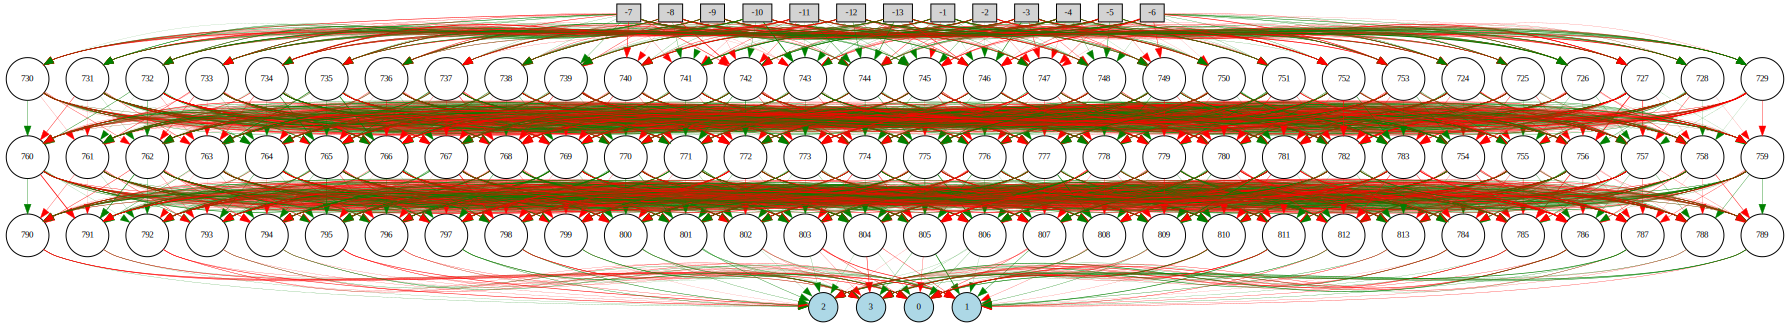

In [16]:
import visualize
with open(save_nn_destination, "rb") as f:
    genome = pickle.load(f)
    print('\nBest genome:\n{!s}'.format(genome))
print(genome.fitness)
config = neat.Config(FixedStructureGenome, neat.DefaultReproduction,
                    neat.DefaultSpeciesSet, neat.DefaultStagnation,
                    'fixed_structure_config')
visualize.draw_net(config, genome, True)